In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np

In [2]:
laser = LaserControl(hcf.LASER_SN)
laser.open()

In [3]:
uncal_choffset = {"laser":0, 
                "dclk":1000.0, 
                "dtrig":1000.0,
                "mwA":0, 
                "mwB":0,
                }
ps = PulseGenerator(ip=hcf.PS_IP, 
                    chmap=hcf.PS_chmap,
                    choffs=uncal_choffset)


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


In [4]:
tb = hcf.NI_timebase
rate_s = 150E3 #Hz # sampling rate
time_s = 1.0/rate_s*1E9 # ns
time_laser = 1200.0
time_idle =  time_s-time_laser
n_runs = 10000
sub_daqtrig = [(["dtrig"], time_s*0.5), ([], tb*10)]
sub_initread = [(["laser", "dclk"], time_laser)]
sub_idle = [([],time_idle)]
seq = sub_daqtrig + (sub_initread + sub_idle) * n_runs

free_time = np.arange(1000.0, 10E6, 1000)

In [5]:
tb = hcf.NI_timebase
rate_s = 200E3 #Hz # sampling rate
time_s = 1.0/rate_s*1E9 # ns
time_laser = 1000.0
time_idle =  time_s-time_laser
n_runs = 1000

daqoffsets = np.arange(-time_s*0.2, time_s*0.5, 5*tb)
num_doff = len(daqoffsets)
doff = 0.0

seq_daqtrig = [(tb*10, LOW), (time_s*0.5, HIGH), (time_s*0.5-tb*10, LOW)]
seq_pad = [(tb*10, LOW), (time_s*0.5, LOW), (time_s*0.5-tb*10, LOW)]
seq_laser = []
seq_daqclk = []
for doff in daqoffsets:
    seq_laser += [(time_s*0.5-doff, LOW), (time_laser, HIGH), (time_s*0.5-time_laser+doff, LOW)]
    seq_daqclk += [(time_s*0.5, LOW), (tb*10, HIGH), (time_s*0.5-tb*10, LOW)]


In [6]:
ps.resetSeq()
ps.setDigital("laser", seq_pad+seq_laser*n_runs)
ps.setDigital("dtrig", seq_daqtrig)
ps.setDigital("dclk", seq_pad+seq_daqclk*n_runs)
ps.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
ps.stream()

In [7]:
min_volt = -0.002 # [V]
max_volt = 0.010

num_readsample = n_runs*num_doff
timeout_read = 5

readtask = nidaqmx.Task("readsignal")
readtask.ai_channels.add_ai_voltage_chan(
            hcf.NI_ch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )

readtask.timing.cfg_samp_clk_timing(
    rate_s, 
    source=hcf.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    # sample_mode=AcquisitionType.CONTINUOUS, 
    sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True
buffer = np.zeros(num_readsample, dtype=np.float64, order='C')

In [8]:
laser_curent = 120.01  #percent
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(laser_curent, save_memory=False)
laser.laser_on() # turn on laser

Failed to set command 'ACC=1'
Response from Device :'Not authorized'


In [9]:
readtask.start() # ready to read data
ps.startNow()
num_read = reader.read_many_sample(
            buffer,
            num_readsample,
            timeout_read
        )
readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
readtask.stop()
ps.forceFinal()
laser.close()
readtask.close()
ps.reset()

In [10]:
data_raw = np.reshape(buffer, (n_runs, num_doff)).T

In [11]:
import matplotlib.pyplot as plt

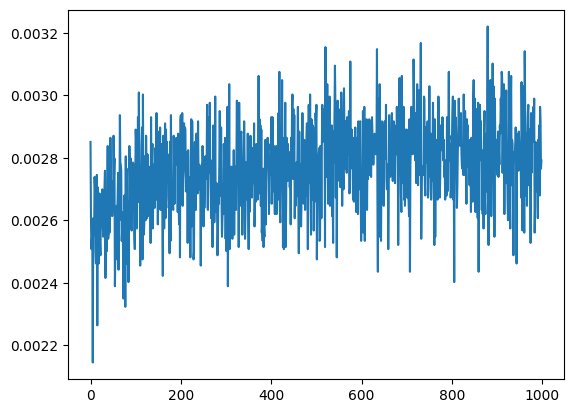

In [12]:
plt.plot(data_raw[40][1:])

In [13]:
pl = np.average(data_raw[:, 1:], axis=1)

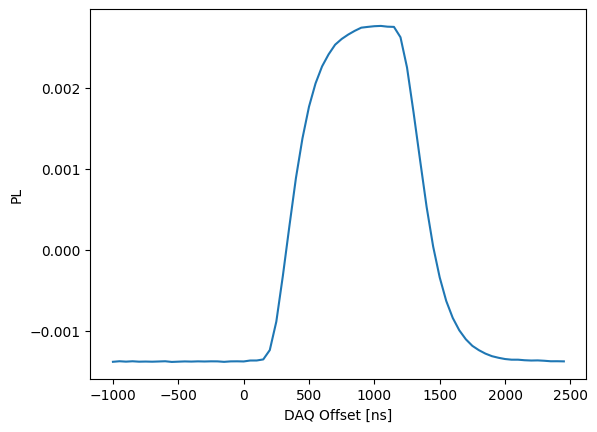

In [14]:
plt.plot(daqoffsets, pl)
plt.xlabel("DAQ Offset [ns]")
plt.ylabel("PL")
plt.show()

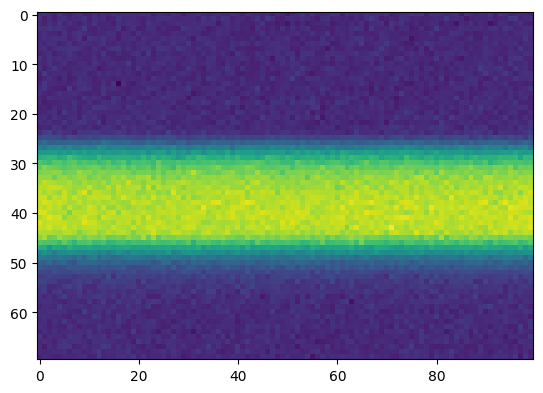

In [15]:
plt.imshow(data_raw[:, 0:100])